In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import rainbow
import os
import glob

## Import the jsonified transactions into a dataframe

In [4]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/'
all_files = glob.glob(os.path.join(path, "*.json"))

In [5]:
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

## Import just one day into a dataframe 

In [6]:
#df=pd.read_json('./jsons/1.json',keep_default_dates=False,lines=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73865 entries, 0 to 3052
Data columns (total 10 columns):
date      73865 non-null object
gross+    73865 non-null float64
gross-    73865 non-null float64
items     73865 non-null object
net       73865 non-null float64
oper      73865 non-null int64
term      73865 non-null int64
time      73865 non-null object
trans     73865 non-null int64
type      73865 non-null object
dtypes: float64(3), int64(3), object(4)
memory usage: 6.2+ MB


In [8]:
def get_items(df,most_common=10,least_common=5):
    df['total_of_items'] = 0
    stoppers = ['BAG CREDIT','SF Bag Charge','Gift Card Reload','8 OZ BIO TUB t3', '16OZ BIO TUB t4',
                 '32OZ BIO TUB t5','BOTTLE DEPOSIT','6PACK BEER SMALL C','PAID IN','Gift Card Sale','PACKAGED FOOD', ]  
    '''build a dictionary where the keys are the words
    in the dataframe items column'''
    
    items=[]
    item_dict = defaultdict(int)
    basket_counts=[]
    
    for basket in df['items']:
        basket_counts.append(len(basket))
        for item in basket:
            
            items.append(item[1])
            item_dict[item[1]] += 1
    
    items_set=set(items)

    
    '''add the most common words to the stopwords list'''
    stopwords=list([i[0] for i in Counter(item_dict).most_common(most_common)])
    
    for s in stoppers:
        stopwords.append(s)
        
    '''add items containing "CRV" to the stopwords list'''
    for item in items_set:
        if "crv" in item.lower():
            stopwords.append(item)
    
    '''add the least common words to the stopwords list'''
    for key,value in item_dict.items():
        if value < least_common:
            stopwords.append(key)
    print(type(stopwords) )  
    stopwords = set(stopwords)
    
    '''iterate through the baskets and add items to items_set
    if not in stopwords (too common or too uncommon)'''
    for stops in stopwords:
        items_set.remove(stops)
  

    return items_set,stopwords, item_dict, basket_counts

items_set,stopwords,item_dict, basket_counts = get_items(df,most_common=5,least_common=5)

<class 'list'>


In [9]:
Counter(item_dict).most_common(25)

[('BAG CREDIT', 58565),
 ('SF Bag Charge', 15698),
 ('SMALL COOLER CRV', 13042),
 ('BANANAS', 10150),
 ('AVOCADOS HASS', 7131),
 ('ONIONS YELLOW', 6301),
 ('APPLES FUJI', 5192),
 ('8 OZ BIO TUB t3', 5004),
 ('CRV LRG SING NOTAX', 4439),
 ('CRV SMALL SING T', 4433),
 ('GARLIC WHITE', 4403),
 ('CRV SMALL NO TAX', 3798),
 ('CELERY', 3772),
 ('Worker 20% PkgFood', 3523),
 ('PEPPERS RED BELL', 3521),
 ('16OZ BIO TUB t4', 3500),
 ('ORANGES NAVEL', 3486),
 ('KALE DINO', 3486),
 ('CARROTS LOOSE', 3366),
 ('GINGER', 3242),
 ('LEMONS', 3180),
 ('BOTTLE DEPOSIT', 3146),
 ('LARGE COOLER CRV', 3064),
 ('SQUASH ZUCCHINI', 3042),
 ('CILANTRO', 3022)]

In [10]:
df['item_count']=basket_counts

In [783]:
percentile = np.percentile(basket_counts, [25, 50, 75])
q1=percentile[0]
q2=percentile[1]
q3=percentile[2]

dfq1=df[(df['item_count']<=q1)]
dfq2=df[(df['item_count']>q1 )& (df['item_count']<=q2)]
dfq3=df[(df['item_count']>q2 )& (df['item_count']<=q3)]
dfq4=df[df['item_count']>q3]
df_avg=df[(df['item_count']>=10 )& (df['item_count']<=12)]

In [784]:
q1,q2,q3

(3.0, 8.0, 16.0)

In [785]:
df = df_avg

In [786]:
df['item_count'].max()

12

In [11]:
item_matrix = np.zeros((df.shape[0],len(items_set)))

In [12]:
df_items= pd.DataFrame(item_matrix,columns=items_set)

In [13]:
df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052],
           dtype='int64', length=73865)

In [14]:
df=df.reset_index()

In [15]:
df.index

RangeIndex(start=0, stop=73865, step=1)

In [16]:
df.describe()

,index,gross+,gross-,net,oper,term,trans,total_of_items,item_count
count,73865.000000,73865.000000,73865.000000,73865.000000,73865.000000,73865.000000,73865.000000,73865.0,73865.000000
mean,1331.635714,119.707593,4.104208,115.603385,129.191782,4.843986,147.200149,0.0,11.241576
std,784.366767,503.477908,88.814536,482.132335,350.556723,2.951749,106.353866,0.0,11.739385
min,0.000000,0.000000,0.000000,-521.080000,1.000000,1.000000,1.000000,0.0,0.000000
25%,659.000000,13.500000,0.000000,13.010000,27.000000,2.000000,61.000000,0.0,3.000000
50%,1319.000000,39.330000,0.000000,38.620000,60.000000,5.000000,128.000000,0.0,8.000000
75%,1978.000000,87.430000,0.000000,85.700000,79.000000,7.000000,215.000000,0.0,16.000000
max,3131.000000,14257.890000,7539.930000,13755.450000,1745.000000,11.000000,583.000000,0.0,156.000000


In [17]:
df.pop('index')
print ()

In [18]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73865 entries, 0 to 73864
Data columns (total 12 columns):
date              73865 non-null object
gross+            73865 non-null float64
gross-            73865 non-null float64
items             73865 non-null object
net               73865 non-null float64
oper              73865 non-null int64
term              73865 non-null int64
time              73865 non-null object
trans             73865 non-null int64
type              73865 non-null object
total_of_items    73865 non-null int64
item_count        73865 non-null int64
dtypes: float64(3), int64(5), object(4)
memory usage: 6.8+ MB


In [19]:
df.iloc[:,0].index


RangeIndex(start=0, stop=73865, step=1)

In [20]:
df_items.iloc[:,0].index

RangeIndex(start=0, stop=73865, step=1)

In [21]:
col_index_dict = dict(zip(items_set, range(len(items_set))))

In [22]:
#col_index_dict

In [23]:
matrix = np.zeros(df_items.shape)
matrix.shape

(73865, 13293)

In [25]:
    for i in range(df.shape[0]):
        for item in df['items'][i]:
            #set matrix to boolean for item precence in basket:
            if item[1] not in stopwords:
                matrix[i,col_index_dict[ item[1] ]] = matrix[i,col_index_dict[ item[1] ]] + item[2]
            '''if item[1] not in stopwords and item[2] > 0:
                matrix[i,col_index_dict[ item[1] ]] = 1
            if item[1] not in stopwords and item[2] < 0:
                matrix[i,col_index_dict[ item[1] ]] = 0'''
    #matrix = (matrix > 0).astype(int)
 

In [26]:
#count rows of baskets with a total of 0 weight items
sum_of_zeros=0
for i in range(matrix.shape[0]):
    if matrix[i].sum()<1:
        sum_of_zeros+=1
print (sum_of_zeros)

9723


In [27]:
print(sum_of_zeros / matrix.shape[0],"% of zero weight baskets")

0.13163203140865093 % of zero weight baskets


In [28]:
#Set all negative values in the matrix to 0.

matrix = (matrix > 0).astype(int)

In [29]:
matrix.shape[0]

73865

In [30]:
sparse_matrix = sparse.csr_matrix(matrix)

In [31]:
sparse_matrix

<73865x13293 sparse matrix of type '<class 'numpy.int64'>'
	with 559885 stored elements in Compressed Sparse Row format>

In [611]:
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics

In [480]:
def nmf_funct(sparse_matrix,n_components=10):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components,max_iter=500)
    W = model.fit_transform(sparse_matrix)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter

In [405]:
for i in range(1,25,5):
        iter=i
        iteration,score,model_iter = scoring(iter,sparse_matrix,matrix)
        print(iteration,score)
        scores.append([iteration,score,model_iter])

1 0.0001431933907664586
6 0.00013688176105176462
11 0.00013384672786558588
16 0.00013140280763105445
21 0.0001291768748997968


In [406]:
just_scores=[]
for s in range(len(scores)):
    just_scores.append(scores[s][1])


In [407]:
scores

[[1, 0.0014292479840451004],
 [2, 0.0014154504580593179],
 [3, 0.0014032661542237052],
 [4, 0.0013923321477350976],
 [5, 0.0013824216984958816],
 [6, 0.0013728834602767983],
 [7, 0.0013635799643995552],
 [8, 0.0013551235423484526],
 [9, 0.001346863101037918],
 [10, 0.0013386838095089419],
 [11, 0.001330587590839945],
 [12, 0.0013223004563320056],
 [13, 0.001314240614156265],
 [14, 0.0013069591545129928],
 [15, 0.0013000231686138171],
 [16, 0.0012930671499918533],
 [17, 0.0012869543212667915],
 [18, 0.001280833991894081],
 [19, 0.0012742805405896848],
 [20, 0.0012679189158443943],
 [21, 0.001262182111047437],
 [22, 0.0012566705248991837],
 [23, 0.0012504598340663843],
 [24, 0.0012443260574233738],
 [1, 0.001462029804203652, 5],
 [6, 0.0013877529690621115, 95],
 [11, 0.0013427198413541964, 96],
 [16, 0.0013029291315034713, 292],
 [21, 0.0012701763318097284, 243],
 [1, 0.0001431933907664586, 6],
 [6, 0.00013688176105176462, 67],
 [11, 0.00013384672786558588, 86],
 [16, 0.00013140280763105

In [408]:
just_scores

[0.0014292479840451004,
 0.0014154504580593179,
 0.0014032661542237052,
 0.0013923321477350976,
 0.0013824216984958816,
 0.0013728834602767983,
 0.0013635799643995552,
 0.0013551235423484526,
 0.001346863101037918,
 0.0013386838095089419,
 0.001330587590839945,
 0.0013223004563320056,
 0.001314240614156265,
 0.0013069591545129928,
 0.0013000231686138171,
 0.0012930671499918533,
 0.0012869543212667915,
 0.001280833991894081,
 0.0012742805405896848,
 0.0012679189158443943,
 0.001262182111047437,
 0.0012566705248991837,
 0.0012504598340663843,
 0.0012443260574233738,
 0.001462029804203652,
 0.0013877529690621115,
 0.0013427198413541964,
 0.0013029291315034713,
 0.0012701763318097284,
 0.0001431933907664586,
 0.00013688176105176462,
 0.00013384672786558588,
 0.00013140280763105445,
 0.0001291768748997968]

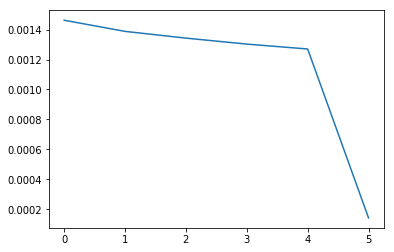

In [409]:
plt.plot(np.arange(len(just_scores[24:30])),(just_scores[24:30]))


In [722]:
scores[24:30]

[[1, 0.001462029804203652, 5],
 [6, 0.0013877529690621115, 95],
 [11, 0.0013427198413541964, 96],
 [16, 0.0013029291315034713, 292],
 [21, 0.0012701763318097284, 243],
 [1, 0.0001431933907664586, 6]]

In [411]:
for i in range(10,101,10):
    iter=i
    print (iter)

10
20
30
40
50
60
70
80
90
100


In [72]:
rebuilt = np.dot(W,H)

NameError: name 'W' is not defined

(73865, 4222)

In [105]:
rebuilt.shape

(73865, 4230)

In [106]:
matrix.shape

(73865, 4230)

In [108]:
rebuilt-matrix

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29976971e-04, 3.29969297e-04, 2.11526977e-04, ...,
        1.46095233e-04, 9.08517333e-04, 6.24379430e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.05683634e-05, 7.16348659e-05, 8.00710503e-05, ...,
        4.00441875e-05, 2.78065699e-04, 2.19722093e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [121]:
np.mean((rebuilt-matrix)**2)

0.09009532798915376

n_components:
1   =  .0001
2   = 0.0013937693036813904
3   = 0.001383618220432841
10  = 0.0013233378763788833
100 =-0.0003337663571822616
100 = 0.001324181632724416

In [129]:
scorer=metrics.explained_variance_score
prediction = model.inverse_transform(model.transform(sparse_matrix))
scorer(matrix, prediction)

0.018682112359056913

In [130]:
prediction


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29976672e-04, 3.29950574e-04, 2.11518553e-04, ...,
        1.46131375e-04, 9.08533609e-04, 6.24109411e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.05695823e-05, 7.16348761e-05, 8.00711799e-05, ...,
        4.00437082e-05, 2.78061313e-04, 2.19714633e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [32]:
from sklearn.decomposition import NMF
model = NMF(n_components=16,max_iter=250)
W = model.fit_transform(sparse_matrix)
H=model.components_
model_iter = model.n_iter_
model,W,H,model_iter

(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=250,
   n_components=16, random_state=None, shuffle=False, solver='cd',
   tol=0.0001, verbose=0),
 array([[0.00000000e+00, 1.97395745e-05, 0.00000000e+00, ...,
         0.00000000e+00, 6.10229776e-05, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.20226291e-02, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.19403166e-04, 1.42874567e-03, 1.10309894e-03, ...,
         4.32974468e-03, 2.49250882e-04, 1.30441319e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 array([[0.        , 0.00666118, 0.        , ..., 0.00490367, 0.        ,
         0.        

In [809]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
LDA_model = LDA(n_components=2,max_iter=10)
LDA_W = model.fit_transform(sparse_matrix)
LDA_H = model.components_


In [810]:
list(items_set)[1000]

'NO AHCC 500mg 60vc'

In [33]:
feature_names=list(items_set).copy()
n_top_words=20
for topic in H:
    print(topic.argsort()[:-n_top_words - 1:-1])
    print ([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])
    print()

[10883  5816  5062 13110  2152  7861  1406 12474  2546   646  1995  3406
  4773  3623  1914  7689  1557  1837  6936  4811]
['KALE DINO', 'COLLARDS', 'POTATOES GARNET', 'CHARD RED', 'BEETS RED LOOSE', 'CUCUMBERS', 'CABBAGE RED', 'POTATOES JAPANESE', 'PARSLEY ITALIAN', 'CHARD RAINBOW', 'DANDELION', 'CAULIFLOWER CELLO', 'BROCCOLI BABY SWEE', 'KALE RED RUSSIAN', 'SQUASH BUTTERNUT', 'MUSHROOMS SHIITAKE', 'LETTUCE ROMAINE', 'KALE RED BOR', 'SQUASH DELICATA', 'BEETS RED BUNCHED']

[ 6316 12694  3853 13007 13043  9297 12474  4081  3357  2152   649  3116
  5378  7542 11884 12192  3295  8947 12342 12072]
['APPLES FUJI', 'PEAR BOSC', 'KIWI LOOSE', 'ORANGES VALENCIA', 'PEARS RED', 'GRAPEFRUIT', 'POTATOES JAPANESE', 'TANGELO MINNEOLA', 'CARA CARA NAVEL', 'BEETS RED LOOSE', 'PARADISO VINTAGE', '3185 ORG MANGO', 'MILTON CHEDDAR', 'EGGS DZ ST JOHN', '5290 WALNUTS', '3080 MEDJOOL DATES', 'ORANGES BLOOD', 'LETTUCE RED LEAF', 'STRAUS MILK 64oz', 'LETTUCE RED BUTTER']

[ 3575   586   653 12094  5062   806

Topic #0:
['KALE DINO', 'COLLARDS', 'POTATOES GARNET', 'CHARD RED', 'BEETS RED LOOSE', 'CUCUMBERS', 'CABBAGE RED', 'POTATOES JAPANESE', 'PARSLEY ITALIAN', 'CHARD RAINBOW', 'DANDELION', 'CAULIFLOWER CELLO', 'BROCCOLI BABY SWEE', 'KALE RED RUSSIAN', 'SQUASH BUTTERNUT', 'MUSHROOMS SHIITAKE', 'LETTUCE ROMAINE', 'KALE RED BOR', 'SQUASH DELICATA', 'BEETS RED BUNCHED', 'ROOT TURMERIC', 'CARROTS BUNCH', 'CABBAGE GREEN', 'WILDWOOD 16oz TOFU', '4110 ORG RLD OATS']


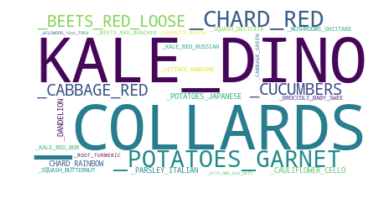

<img src="topic0.png">
Topic #1:
['APPLES FUJI', 'PEAR BOSC', 'KIWI LOOSE', 'ORANGES VALENCIA', 'PEARS RED', 'GRAPEFRUIT', 'POTATOES JAPANESE', 'TANGELO MINNEOLA', 'CARA CARA NAVEL', 'BEETS RED LOOSE', 'PARADISO VINTAGE', '3185 ORG MANGO', 'MILTON CHEDDAR', 'EGGS DZ ST JOHN', '5290 WALNUTS', '3080 MEDJOOL DATES', 'ORANGES BLOOD', 'LETTUCE RED LEAF', 'STRAUS MILK 64oz', 'LETTUCE RED BUTTER', '5120 ORG ALMONDS', 'POTATOES RUSSET', 'POTATOES GARNET', '4110 ORG RLD OATS', 'CLEMENTINE TANGERI']


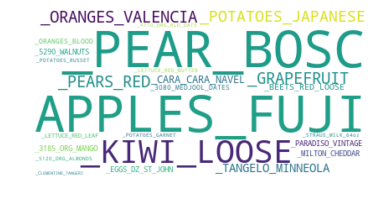

<img src="topic1.png">
Topic #2:
['ONIONS YELLOW', 'POTATOES YELLOW', 'POTATOES RUSSET', 'MUSHROOM CRIMINI', 'POTATOES GARNET', 'LEEKS', 'SHALLOTS', 'SQUASH BUTTERNUT', 'CAULIFLOWER CELLO', 'PEPPERS GREEN BELL', 'ROOTS PARSNIP', 'CABBAGE GREEN', 'EGGS DZ ST JOHN', '3680 BAKERS CH FLO', 'STRAUS PLN YOG QT', '8036 BAY LEAF ORG', 'EGGPLANT GLOBE', 'MILTON CHEDDAR', 'PARMIGIANO REGG', 'ORG 1LB BUTTER', '2220 ORG RED LNTL', 'POTATOES FINGERLIN', 'GARLIC PURPLE', 'POTATOES JAPANESE', 'BEETS GOLD LOOSE']


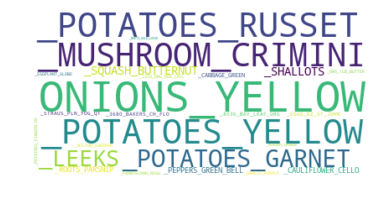

<img src="topic2.png">
Topic #3:
['GARLIC WHITE', 'SHALLOTS', 'MUSHROOM CRIMINI', 'ONIONS WHITE', 'MUSHROOMS SHIITAKE', 'PARMIGIANO REGG', 'POTATOES RUSSET', 'LEMONS MEYER', 'EGGPLANT GLOBE', 'POTATOES YELLOW', 'HERBS BUNCH', 'ONIONS GREEN', 'BASIL 4oz PACKAGE', '4125 OG STL CUT OA', 'EGGS DZ ST JOHN', 'LEEKS', 'PARSLEY ITALIAN', 'PEPPER CHILI', 'ORANGES BLOOD', 'PARMIGIANO REGGIAN', 'SHIITAKES BABY', 'TOMATOES ROMA', '4110 ORG RLD OATS', 'HERBS THYME CLMSH', 'WHOLE ORG MILK']


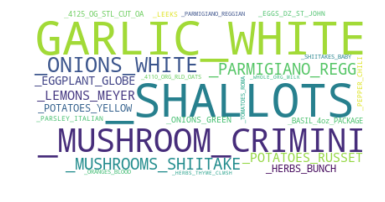

<img src="topic3.png">
Topic #4:
['CELERY', 'PARSLEY ITALIAN', 'CUCUMBERS', 'LEEKS', 'FENNEL', 'BEETS RED LOOSE', 'POTATOES YELLOW', 'CARROTS BUNCH', 'SPINACH BUNCHED', 'HERBS BUNCH', 'COLLARDS', 'PARSLEY CURLY', 'ROOT TURMERIC', 'LETTUCE ROMAINE', 'CABBAGE GREEN', 'KALE GREEN', 'CHARD RED', 'CABBAGE RED', 'DANDELION', 'LIL GEM LETTUCE', 'ARTICHOKES', 'CUCUMBERS ENGLISH', 'ROOTS PARSNIP', 'ASPARAGUS', 'BROCCOLI BABY SWEE']


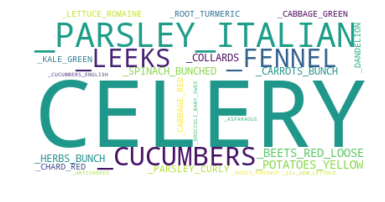

<img src="topic4.png">
Topic #5:
['PEPPERS RED BELL', 'PEPPERS ORANGE BEL', 'PEPPERS YELLOW BEL', 'PEPPERS GREEN BELL', 'CUCUMBERS', 'SUGAR PLUM CLAM', 'TOMATOES ROMA', 'PEPPER CHILI', 'EGGPLANT GLOBE', 'LETTUCE SALAD MIX', 'MUSHROOM CRIMINI', 'CUCUMBERS ENGLISH', 'LETTUCE RED LEAF', 'LETTUCE ROMAINE', 'PEAS SNAP', 'CABBAGE RED', 'CAULIFLOWER CELLO', 'POTATOES GARNET', 'APPLES PINK LADY', 'CHERRY TOMATO CLAM', 'APPLE HONEYCRISP', 'POTATOES RED', 'LETTUCE RED ROMAIN', 'BEANS GREEN', 'LETTUCE GREEN LEAF']


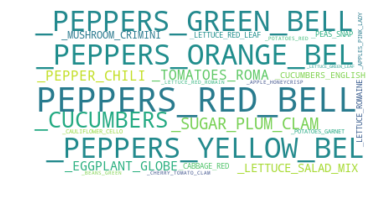

<img src="topic5.png">
Topic #6:
['ORANGES NAVEL', 'GRAPEFRUIT', 'PEAR BOSC', 'APPLES PINK LADY', 'APPLE HONEYCRISP', 'POTATOES RUSSET', 'KIWI LOOSE', 'POTATOES GARNET', 'MILTON CHEDDAR', 'LETTUCE RED LEAF', 'POTATOES YELLOW', 'TOMATOES CLUSTER', 'TOMATOES ROMA', 'ORANGES BLOOD', '4110 ORG RLD OATS', 'LIMES', 'TANGELO MINNEOLA', 'CABBAGE RED', 'ORGANIC 2% MILK', 'WHOLE ORG MILK', 'ORG WM QT CLOVER', 'COLLARDS', 'EGGPLANT GLOBE', 'PEARS RED', 'SPINACH BUNCHED']


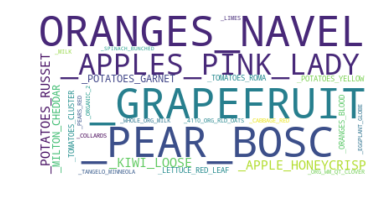

<img src="topic6.png">
Topic #7:
['CILANTRO', 'PEPPER CHILI', 'LIMES', 'ONIONS GREEN', 'PARSLEY ITALIAN', 'HERBS BUNCH', 'TOMATOES ROMA', 'SHALLOTS', 'CABBAGE GREEN', 'DILL', 'ONIONS WHITE', 'LEMONS MEYER', 'CAULIFLOWER CELLO', 'LEMONGRASS', 'FENNEL', 'PEPPERS GREEN BELL', 'BOK CHOY BABY', 'ORG Y CORN TORT', 'TOMATO MIX HEIRLOO', 'BROCCOLI BABY SWEE', 'MUSHROOMS SHIITAKE', 'CUCUMBERS ENGLISH', 'TOMATOES CLUSTER', 'CABBAGE RED', 'TOMATILLOS']


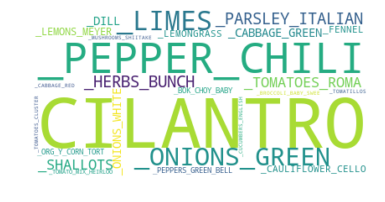

<img src="topic7.png">
Topic #8:
['GINGER', 'ROOT TURMERIC', 'MUSHROOMS SHIITAKE', 'POTATOES GARNET', '8571 TURM PWD ORG', 'BEETS RED LOOSE', 'BOK CHOY BABY', 'GARLIC PURPLE', 'LEMONGRASS', 'LEMONS MEYER', 'SHALLOTS', 'PEAR BOSC', 'KALE GREEN', '8160 CUMIN SD ORG', '2220 ORG RED LNTL', '5120 ORG ALMONDS', 'FENNEL', 'BRUSSEL SPROUTS', 'DAIKON', 'POTATOES JAPANESE', '5150 BRAZIL NUTS', 'ONIONS GREEN', 'DANDELION', 'CABBAGE NAPA', '8083 CARD POD ORG']


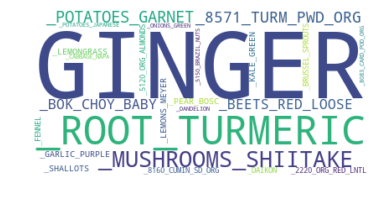

<img src="topic8.png">
Topic #9:
['LEMONS', 'LIMES', 'PARSLEY ITALIAN', 'GRAPEFRUIT', 'CUCUMBERS', 'HERBS BUNCH', 'CAULIFLOWER CELLO', 'SHALLOTS', 'ORANGES BLOOD', 'FENNEL', 'ORANGES VALENCIA', 'DILL', 'CUCUMBERS ENGLISH', 'TOMATO MIX HEIRLOO', 'TANGELO MINNEOLA', 'super greens', 'MANGO', 'PARMIGIANO REGG', 'MIX CHERRY TOMATO', 'CARA CARA NAVEL', 'KALE GREEN', 'ROMANESQUE', 'BEETS RED LOOSE', 'BABY ARUGULA CLAM', '2448 CASTEL OLIVE']


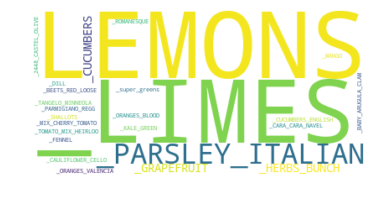

<img src="topic9.png">
Topic #10:
['SATSUMA MANDARIN', 'KIWI LOOSE', 'PEAR BOSC', 'BLUEBERRIES', 'GRAPEFRUIT', 'ORANGES BLOOD', 'RASPBERRY', 'CARA CARA NAVEL', 'POTATOES YELLOW', 'MANGO', 'PARADISO VINTAGE', 'APPLES PINK LADY', '3185 ORG MANGO', 'REFRIGERATED', 'LEMONS MEYER', 'WHOLE ORG MILK', 'MANGO ATAULFO', 'APPLES GALA', 'STRAWBERRY 1LB PKG', 'PEARS RED', 'TOMATO MIX HEIRLOO', 'LIL GEM LETTUCE', 'AVOCADO FUERTE', 'LIMES', 'TANGELO MINNEOLA']


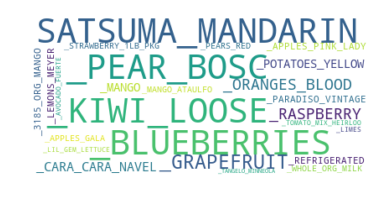

<img src="topic10.png">
Topic #11:
['SQUASH ZUCCHINI', 'BEANS GREEN', 'EGGPLANT GLOBE', 'MUSHROOM CRIMINI', 'CAULIFLOWER CELLO', 'POTATOES GARNET', 'POTATOES YELLOW', 'SQUASH SUNBURST', 'LEEKS', 'TOMATOES ROMA', 'CABBAGE GREEN', 'ASPARAGUS', 'CHARD RED', 'POTATOES RED', 'BOK CHOY BABY', 'PEPPERS GREEN BELL', 'PEPPERS YELLOW BEL', 'BRUSSEL SPROUTS', 'MUSHROOMS SHIITAKE', 'CHARD RAINBOW', 'SHIITAKES BABY', 'CAULIFLOWER BULK', 'PEAR BOSC', 'FENNEL', 'SPINACH BUNCHED']


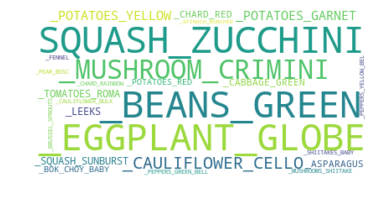

<img src="topic11.png">
Topic #12:
['CARROTS LOOSE', 'LETTUCE SALAD MIX', 'POTATOES GARNET', 'BEETS RED LOOSE', 'MUSHROOM CRIMINI', 'POTATOES RUSSET', 'SPINACH LOOSE', 'TOMATOES ROMA', 'POTATOES YELLOW', 'LEEKS', 'CUCUMBERS', 'CABBAGE GREEN', 'PEAR BOSC', 'POTATOES JAPANESE', 'ROOTS PARSNIP', 'BEANS GREEN', '5290 WALNUTS', 'ARUGULA LOOSE', 'CABBAGE RED', 'ONIONS GREEN', 'CAULIFLOWER CELLO', 'ROOTS TURNIP LOOSE', '4110 ORG RLD OATS', 'LETTUCE RED LEAF', '4105 QUICK OATS']


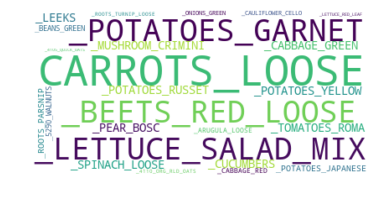

<img src="topic12.png">
Topic #13:
['CARROTS BUNCH', 'SPINACH LOOSE', 'BEANS GREEN', 'BLUEBERRIES', 'ARUGULA LOOSE', 'MUSHROOM CRIMINI', 'BAGEL', '5290 WALNUTS', 'CUCUMBERS', 'SUGAR PLUM CLAM', 'LETTUCE SALAD MIX', 'TOMATO MIX HEIRLOO', '4110 ORG RLD OATS', 'RASPBERRY', 'MILTON CHEDDAR', 'PEAR BOSC', 'POTATOES GARNET', 'MUSHROOMS SHIITAKE', 'KIWI LOOSE', 'BROCCOLI BABY SWEE', 'BLACKBERRY PACK', 'ORANGES BLOOD', 'BRUSSEL SPROUTS', 'APPLES PINK LADY', 'ONIONS GREEN']


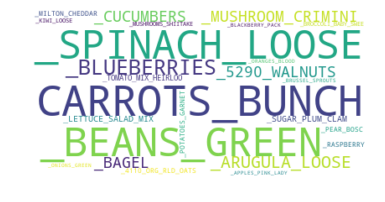

<img src="topic13.png">
Topic #14:
['ONIONS RED', 'TOMATOES ROMA', 'POTATOES GARNET', 'CABBAGE RED', 'TOMATO MIX HEIRLOO', 'ONIONS WHITE', 'POTATOES YELLOW', 'MUSHROOM CRIMINI', 'SUGAR PLUM CLAM', 'TOMATOES CLUSTER', 'PARSLEY ITALIAN', 'EGGPLANT GLOBE', 'DILL', 'MIX CHERRY TOMATO', 'MUSHROOMS SHIITAKE', 'HERBS BUNCH', 'BEETS RED LOOSE', 'PEPPERS GREEN BELL', 'BROCCOLI BABY SWEE', 'LETTUCE ROMAINE', 'ORG Y CORN TORT', 'FENNEL', 'BULGARIAN FETA', 'POTATOES JAPANESE', 'MUSHROOM PORTOBELL']


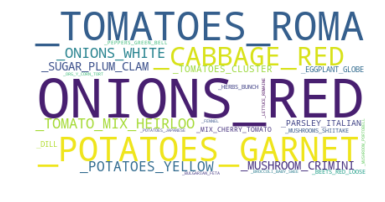

<img src="topic14.png">
Topic #15:
['BROCCOLI LOOSE', 'POTATOES GARNET', 'CAULIFLOWER CELLO', 'POTATOES RUSSET', 'CABBAGE RED', 'BRUSSEL SPROUTS', 'BEANS GREEN', 'CABBAGE GREEN', 'LETTUCE RED LEAF', '4110 ORG RLD OATS', 'KALE GREEN', 'CAULIFLOWER BULK', 'BEETS RED LOOSE', 'CHARD RED', 'APPLES PINK LADY', 'PEAR BOSC', 'SPINACH BUNCHED', 'TOMATOES ROMA', 'SPINACH LOOSE', 'SPROUTED FIRM TOFU', 'PEAS SNAP', 'ORANGES VALENCIA', 'POTATOES RED', 'MUSHROOMS SHIITAKE', 'COLLARDS']


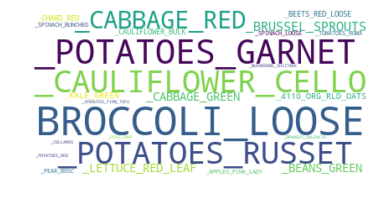

<img src="topic15.png">


In [45]:
def print_top_items(model, feature_names, n_top_words):
    topic_dict = defaultdict()
    topics =[]
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        #topic_string=(" ".join([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]))
        topic_string=[feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx]=topic_string
        topics.append(topic_string)
        print(topic_string)
        #print()
        wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)
        print('<img src="topic%d.png">'%topic_idx)
    return topic_dict
topics = print_top_items(model,list(items_set),25)
#print("stopwords:",stopwords,"number of topics:",len(topics))

In [35]:
topics3=topics.copy()

In [38]:
topic_compare =np.zeros([len(topics),len(topics)])

for topic in topics:
    for item in topics[topic]:
        for topic2 in topics:
            #print (item)
            #print (type(topics[topic2]))
            if item in topics[topic2]:
                topic_compare[topic,topic2]+=1
            
print(topic_compare)


[[25.  4.  5.  3. 12.  5.  4.  6.  6.  4.  0.  6.  8.  6.  8.  9.]
 [ 4. 25.  5.  4.  1.  2. 11.  0.  5.  6.  9.  2.  8.  7.  3.  7.]
 [ 5.  5. 25.  8.  4.  5.  5.  4.  5.  3.  1.  8.  9.  3.  6.  4.]
 [ 3.  4.  8. 25.  4.  4.  7.  9.  4.  5.  4.  7.  7.  5.  8.  4.]
 [12.  1.  4.  4. 25.  4.  4.  7.  5.  7.  2.  7.  7.  3.  8.  7.]
 [ 5.  2.  5.  4.  4. 25.  7.  6.  1.  3.  1.  9.  9.  7.  8.  9.]
 [ 4. 11.  5.  7.  4.  7. 25.  4.  2.  4. 10.  6.  8.  7.  6. 10.]
 [ 6.  0.  4.  9.  7.  6.  4. 25.  7.  9.  3.  7.  5.  4. 13.  5.]
 [ 6.  5.  5.  4.  5.  1.  2.  7. 25.  4.  2.  6.  5.  5.  5.  6.]
 [ 4.  6.  3.  5.  7.  3.  4.  9.  4. 25.  7.  2.  3.  3.  7.  4.]
 [ 0.  9.  1.  4.  2.  1. 10.  3.  2.  7. 25.  2.  2.  7.  2.  2.]
 [ 6.  2.  8.  7.  7.  9.  6.  7.  6.  2.  2. 25.  9.  6.  8. 12.]
 [ 8.  8.  9.  7.  7.  9.  8.  5.  5.  3.  2.  9. 25. 11.  7. 12.]
 [ 6.  7.  3.  5.  3.  7.  7.  4.  5.  3.  7.  6. 11. 25.  6.  8.]
 [ 8.  3.  6.  8.  8.  8.  6. 13.  5.  7.  2.  8.  7.  6. 25. 

In [39]:
list_of_topics=[]
for topic in topics:
     list_of_topics.append(topics[topic])

In [40]:
len(topics[0])

25

In [41]:
ingredients =np.array((len(topics),len(topics[0])))
for row in topics:
    print('row',row)
    for i,item in enumerate(topics[row]):
        if item not in topics[row]:
            print ('i',i,item)
            
        if item not in topics[0]:
            print ('iI',i,item)
        #ingredients[row:i]=item
ingredients

row 0
row 1
iI 0 APPLES FUJI
iI 1 PEAR BOSC
iI 2 KIWI LOOSE
iI 3 ORANGES VALENCIA
iI 4 PEARS RED
iI 5 GRAPEFRUIT
iI 7 TANGELO MINNEOLA
iI 8 CARA CARA NAVEL
iI 10 PARADISO VINTAGE
iI 11 3185 ORG MANGO
iI 12 MILTON CHEDDAR
iI 13 EGGS DZ ST JOHN
iI 14 5290 WALNUTS
iI 15 3080 MEDJOOL DATES
iI 16 ORANGES BLOOD
iI 17 LETTUCE RED LEAF
iI 18 STRAUS MILK 64oz
iI 19 LETTUCE RED BUTTER
iI 20 5120 ORG ALMONDS
iI 21 POTATOES RUSSET
iI 24 CLEMENTINE TANGERI
row 2
iI 0 ONIONS YELLOW
iI 1 POTATOES YELLOW
iI 2 POTATOES RUSSET
iI 3 MUSHROOM CRIMINI
iI 5 LEEKS
iI 6 SHALLOTS
iI 9 PEPPERS GREEN BELL
iI 10 ROOTS PARSNIP
iI 12 EGGS DZ ST JOHN
iI 13 3680 BAKERS CH FLO
iI 14 STRAUS PLN YOG QT
iI 15 8036 BAY LEAF ORG
iI 16 EGGPLANT GLOBE
iI 17 MILTON CHEDDAR
iI 18 PARMIGIANO REGG
iI 19 ORG 1LB BUTTER
iI 20 2220 ORG RED LNTL
iI 21 POTATOES FINGERLIN
iI 22 GARLIC PURPLE
iI 24 BEETS GOLD LOOSE
row 3
iI 0 GARLIC WHITE
iI 1 SHALLOTS
iI 2 MUSHROOM CRIMINI
iI 3 ONIONS WHITE
iI 5 PARMIGIANO REGG
iI 6 POTATOES RUSSET
iI

array([16, 25])

In [42]:
len(ing_set)

NameError: name 'ing_set' is not defined

In [225]:
ing_index_dict = dict(zip(ing_set, range(len(ing_set))))

In [231]:
ingredients=np.array(ingredients)
ingredients=ingredients.reshape(5,55)

In [233]:
ingredients.shape

(5, 55)

In [234]:
ing_matrix=np.zeros(ingredients.shape)

In [244]:
for row,col in enumerate(ingredients):
    for i,c in enumerate(col):
        #print(row,i,c)
        ing_matrix[row,i]=ing_index_dict[c]
ing_matrix

array([[ 63.,  99.,  42.,  64., 112.,  14.,  21., 124.,  32.,  35.,  88.,
         68., 121., 130., 113., 120.,  38.,  95., 134.,  10.,  23.,  16.,
         27.,  41.,  96., 118.,  58., 101., 105.,  85.,  97.,  47.,  86.,
         29.,  20.,  91.,  15.,  55., 102.,  28.,  98.,   1., 119., 122.,
        132.,  11., 128.,  65.,  17.,  72.,  54.,   0.,  81., 125.,  25.],
       [100.,  32.,  64.,  19.,  88.,   1., 120.,  86.,   3.,   9.,  39.,
        105., 134.,  41.,  78.,  69.,  93., 131., 124.,  48.,  34.,  97.,
         67.,  57., 112.,  62.,  74.,   7.,  16.,  44., 115.,  91.,  65.,
         11., 123.,  14.,  68.,  53., 107.,  51.,  31.,   6.,  98., 102.,
         24., 121.,  61.,  49.,  55.,  12.,  82., 101., 133.,  60.,  75.],
       [ 37., 115.,  96.,  97.,  21.,   1.,  58.,  77.,  35.,   3., 105.,
        118.,  71., 130.,  85., 131., 104.,  87.,  19.,  15.,  43.,  38.,
        101.,   0.,  41.,   2.,  13., 127.,  62., 121.,  18.,  89.,  32.,
        102.,  50., 126.,  65.,  30.

In [255]:
ing_array=ing_index_dict.values()

ing_array

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134])

In [259]:
for i in ing_matrix:
    print(ing_array==i)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False

In [226]:
for ing_index_dict

{'SPINACH BUNCHED': 0,
 'POTATOES YELLOW': 1,
 'ROOTS TURNIP LOOSE': 2,
 'POTATOES RUSSET': 3,
 'SATSUMA MANDARIN': 4,
 'ORGANIC 2% MILK': 5,
 'PARMIGIANO REGGIAN': 6,
 'ORG 1LB BUTTER': 7,
 'BAG PINK LADY APPL': 8,
 '4110 ORG RLD OATS': 9,
 'TOMATO MIX HEIRLOO': 10,
 'GREEN ONIONS': 11,
 'BRUSSEL SPROUTS': 12,
 'PEAR BOSC': 13,
 'ONIONS GREEN': 14,
 'KALE GREEN': 15,
 'ORANGES BLOOD': 16,
 'CHARD RAINBOW': 17,
 'POTATOES RED': 18,
 'MUSHROOM CRIMINI': 19,
 'CUCUMBERS ENGLISH': 20,
 'PARSLEY ITALIAN': 21,
 'BLUEBERRIES': 22,
 'BROCCOLI BABY SWEE': 23,
 'CLO UNSALTED BUTTE': 24,
 'DAIKON WATERMELON': 25,
 '2215 ORGANIC LENTI': 26,
 'GRAPEFRUIT': 27,
 'RADDICHIO': 28,
 'BOK CHOY BABY': 29,
 'PEPPERS GREEN BELL': 30,
 'ORG WM QT CLOVER': 31,
 'ONIONS RED': 32,
 'STRAUS PLN YOG QT': 33,
 'EGGS DZ ST JOHN': 34,
 'KALE DINO': 35,
 '3080 MEDJOOL DATES': 36,
 'CELERY': 37,
 'CAULIFLOWER CELLO': 38,
 'EGGPLANT GLOBE': 39,
 'DAIKON': 40,
 'TOMATOES ROMA': 41,
 'LIMES': 42,
 'CHARD RED': 43,
 'BA

In [43]:
def print_basket_contents(basket_id):
    basket=[]
    #print('+++++++++++++++++++++++next basket+++++++++++++++++')
    for items in df['items'][basket_id]:
        #for item in items:
        print("item:",items)
    #return basket
#print_basket_contents(1116)

In [44]:
def print_top_baskets(model, W, n_top_words):
    baskets = []
    for topic_idx, w in enumerate(W.T):
        basket_string=str([df['items'][i] for i in w.argsort()[:-n_top_words - 1:-1]])
        count = 0
        for i in w.argsort()[:-n_top_words - 1:-1]:
            count+=1
            print("++++++++++++++++++Topic #%d, basket #%d+++++++++++++++++++"%(topic_idx,count))
            print_basket_contents(i)
        #print_basket_contents([i for i in w.argsort()[:-n_top_words - 1:-1]])
        baskets.append(basket_string)
        #print(basket_string)
        #print()
        '''wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(basket_string.replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)'''
print_top_baskets(model,W,10)

++++++++++++++++++Topic #0, basket #1+++++++++++++++++++
item: ['', 'SR Echinacea Purpu', 12.31, 1]
item: ['', 'Now Elderberry Ext', 12.0, 1]
item: ['', 'GINGER', 1.65, 12]
item: ['', 'KALE RED BOR', 2.49, 12]
item: ['', '8457 PSYLLIUM HUSK', 15.6, 31]
item: ['', 'CELERY', 4.87, 12]
item: ['', 'KALE RED RUSSIAN', 1.99, 12]
item: ['', '6556 DUTCH COCOA', 2.59, 16]
item: ['', 'LEMONS', 3.89, 12]
item: ['', '4oz plstc sqz t4', 0.5, 4]
item: ['', '4oz plstc sqz t4', 0.5, 4]
item: ['', '4oz plstc sqz t4', 0.5, 4]
item: ['', 'COLLARDS', 2.49, 12]
item: ['', 'APPLE HONEYCRISP', 3.83, 12]
item: ['', 'SPROUTS ALFALFA', 2.59, 12]
item: ['', 'KALE DINO', 1.99, 12]
item: ['', 'GREEN CHARD', 1.99, 12]
item: ['', 'KALE GREEN', 1.99, 12]
item: ['', 'CHARD RAINBOW', 1.99, 12]
item: ['', 'CHARD RED', 1.99, 12]
item: ['', 'KALE DINO', 1.99, 12]
item: ['', 'SPINACH BUNCHED', 2.99, 12]
item: ['', 'CUCUMBERS', 4.92, 12]
item: ['', 'BEETS RED LOOSE', 3.44, 12]
item: ['', 'KHC GRIZZLY CLAW', 10.89, 15]
item:

++++++++++++++++++Topic #2, basket #1+++++++++++++++++++
item: ['', '5357 SUNBUTTER', 15.82, 16]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'CHARD RAINBOW', 1.99, 12]
item: ['', 'APPLES PINK LADY', 6.31, 12]
item: ['', 'POTATOES YELLOW', 16.88, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'BANANAS', 12.81, 12]
item: ['', 'WW LAVASH', 2.89, 17]
item: ['', 'SAVORY BAKED TOFU', 45.24, 13]
item: ['', 'PURPLE SWT POTATO', 14.8, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'POTATOES RUSSET', 2.39, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'EGGPLANT GLOBE', 2.66, 12]
item: ['', 'ONIONS YELLOW', 0.9, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'LEEKS', 5.5600000000000005, 12]
item: ['', 'NWMN VAN CREME CKY', 2.99, 15]
item: ['', 'NWMN VAN CREME CKY', 2.99, 15]
item: ['', 'FAKIN BACON', 4.99, 13]
item: ['VD', 'FAKIN BACON', -4.99, 13]
item: ['', 'FAKIN BACON', 53.88, 13]
item: ['', 'CAULIFLOWER BULK', 11.18, 12]
ite

item: ['', 'TRADITIONAL TORTIL', 5.19, 17]
item: ['', 'SQUASH DELICATA', 2.29, 12]
item: ['', 'PYREX 2C CONTAINER', 4.99, 6]
item: ['', 'PYREX 2C CONTAINER', 4.99, 6]
item: ['', 'PYREX 2C CONTAINER', 19.96, 6]
item: ['', 'PARSLEY CURLY', 1.99, 12]
item: ['', 'EGGS DZ ST JOHN', 7.29, 13]
item: ['', 'GARLIC WHITE', 1.4, 12]
item: ['', 'BEETS RED LOOSE', 1.6099999999999999, 12]
item: ['', 'KIWI LOOSE', 2.69, 12]
item: ['', 'TOMATOES ROMA', 2.67, 12]
item: ['', 'CELERY', 3.88, 12]
item: ['', 'CILANTRO', 1.99, 12]
item: ['', 'CILANTRO', 1.99, 12]
item: ['', 'FLAVORG VANILLA4oz', 15.49, 15]
item: ['', 'FLAVORG VANILLA4oz', 15.49, 15]
item: ['VD', 'FLAVORG VANILLA4oz', -15.49, 15]
item: ['', 'FENNEL', 2.03, 12]
item: ['', 'TOMATOES CLUSTER', 4.19, 12]
item: ['', 'MUSHROOM CRIMINI', 11.25, 12]
item: ['', 'PARSLEY ITALIAN', 1.99, 12]
item: ['', '2552 OLIVES wCUMI', 1.8599999999999999, 16]
item: ['', '8 OZ BIO TUB t3', 0.30000000000000004, 36]
item: ['', 'APPLES FUJI', 6.97, 12]
item: ['', 'HERB

item: ['', '3685 WW BREAD FLOU', 3.88, 16]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['MP', 'BAG CREDIT', -0.9500000000000001, 23]
item: ['', '2235 ORG BABY LIMA', 2.51, 16]
item: ['', 'WOOD ALMD BUTTER', 11.49, 15]
item: ['', 'STARTER Pastry', 3.49, 17]
item: ['', '5140 TAMARI ALMOND', 6.5600000000000005, 16]
item: ['', '6880 ORG CANE SUGA', 4.64, 16]
item: ['', 'EGGS ST JOHN 6 PK', 4.29, 13]
item: ['', '5670 SAFFLOWER OIL', 2.5300000000000002, 16]
item: ['', '5657 OG OLIVE OIL', 5.93, 16]
item: ['', 'ITALIAN SAUSAGE', 5.39, 13]
item: ['', '2863 BTR CHOC CHIP', 4.33, 16]
item: ['', '2430 KALAMATA OLIV', 4.05, 16]
item: ['', 'PEAR BOSC', 4.14, 12]
item: ['', 'ONIONS YELLOW', 0.5700000000000001, 12]
item: ['', 'GRAPEFRUIT', 7.9, 12]
item: ['', 'GARLIC WHITE', 1.33, 12]
item: ['', 'HERITAGE FLAKE bag', 9.99, 15]
item: ['', 'APPLES PINK LADY', 7.12, 12]
item: ['', 'APPLES FUJI', 6.73, 12]
item: ['', 'GINGER', 1.15, 12]
item: ['', 'FREY RED TABLE WIN', 9.99, 10]
item: ['', 'CAL OLIVE OIL

item: ['', '8556TURMERICCOCO', 11.04, 11]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'GINGER', 0.35000000000000003, 12]
++++++++++++++++++Topic #8, basket #4+++++++++++++++++++
item: ['', 'TOBYS TOFU DIP', 7.18, 13]
item: ['', 'Henna Gold Cond', 8.95, 4]
item: ['', 'Henna Gold Shampoo', 8.95, 4]
item: ['', 'GOPI PANEER', 6.89, 14]
item: ['', 'TOFURKY SPINA SAUS', 5.39, 13]
item: ['', 'GARD BEEFLESS BURG', 5.49, 19]
item: ['', 'NOCCIOLATA', 6.99, 15]
item: ['', 'NOCCIOLATA', 6.99, 15]
item: ['', 'SQUASH DELICATA', 7.32, 12]
item: ['', 'BUNCH SPINACH', 7.58, 12]
item: ['', 'PLAIN NAAN', 4.99, 17]
item: ['', 'CARROTS LOOSE', 2.05, 12]
item: ['', 'CALIFIA UNSWT', 4.69, 13]
item: ['', 'LARGE COOLER CRV', 0.1, 13]
item: ['', 'STRAU GREEK YOGURT', 8.69, 13]
item: ['', 'STRAUS PLN YOG QT', 5.39, 13]
item: ['', 'BEYOND BURGER', 6.69, 13]
item: ['', 'PARADISO VINTAGE', 5.22, 14]
item: ['', 'ITALIAN MONTASIO', 4.95, 14]
item: ['', 'GUAVA PASTE', 0.99, 14]
item: ['', 'GUAVA PASTE', 0.99, 14]

item: ['', 'BAMBU PAN SCRAPER', 1.99, 6]
item: ['', 'GOOD CUL STRAW', 1.79, 13]
item: ['', 'AVOCADOS HASS', 1.6800000000000002, 12]
item: ['', '8 OZ BIO TUB t3', 0.30000000000000004, 36]
item: ['', '2448 CASTEL OLIVE', 3.6, 16]
item: ['', 'GOOD CULTR PINA', 1.79, 13]
item: ['', 'STICK INCENSE', 9.95, 8]
item: ['', 'Qualita Oro Espres', 9.59, 15]
item: ['', 'FRANK MYRRH', 9.95, 8]
item: ['', 'SOY CANDLE TRAVEL', 3.75, 7]
item: ['', 'ORANGES BLOOD', 1.04, 12]
item: ['', 'GOOD CUL STRAW', 1.79, 13]
item: ['', 'FLORAL SAGE BUNDLE', 10.25, 8]
item: ['', 'AROMATHERAPY TIN', 4.59, 7]
item: ['', '8 OZ BIO TUB t3', 0.30000000000000004, 36]
item: ['', '2458 PITD GRN OLIV', 3.42, 16]
item: ['', 'PEAR BOSC', 0.88, 12]
item: ['', 'LIMES', 0.6900000000000001, 12]
item: ['MR', 'SF Bag Charge', 0.4, 20]
++++++++++++++++++Topic #9, basket #10+++++++++++++++++++
item: ['', 'BL FlaxOil 32oz Li', 39.71, 1]
item: ['', 'BLACKBERRY SPREAD', 3.39, 15]
item: ['', 'Unsalted Virginia', 6.29, 15]
item: ['MP', 'BA

item: ['', 'LL TOFU PUPS', 4.29, 13]
item: ['', 'FROZEN SOBA NOODLE', 5.59, 19]
item: ['', 'OG KETCHUP', 4.49, 15]
item: ['', 'SPROUTED SILKEN TO', 2.39, 13]
item: ['', 'SPROUTED SILKEN TO', 2.39, 13]
item: ['', '3120 DRD APRICOT', 13.96, 16]
item: ['', 'AVOCADOS HASS', 7.62, 12]
item: ['', 'SQUASH ZUCCHINI', 2.91, 12]
item: ['', 'MUSHROOMS KING TRU', 11.05, 12]
item: ['', 'MEDIUM TOFU', 2.39, 13]
item: ['', '5 LB SUSHI RICE', 11.59, 16]
item: ['', 'BOK CHOY BABY', 3.23, 12]
item: ['', 'GINGER PEACH GREEN', 2.99, 15]
++++++++++++++++++Topic #11, basket #4+++++++++++++++++++
item: ['', 'Bulk Soap', 1.9500000000000002, 4]
item: ['', 'BEANS GREEN', 1.35, 12]
item: ['', 'DILL', 2.99, 12]
item: ['', 'CABBAGE GREEN', 1.76, 12]
item: ['', 'LEEKS', 1.67, 12]
item: ['', 'DAIKON', 1.25, 12]
item: ['', 'PARSLEY ITALIAN', 1.99, 12]
item: ['', 'CELERY', 1.18, 12]
item: ['', 'CADIA TOM PASTE', 1.3900000000000001, 15]
item: ['', 'BEETS RED LOOSE', 3.1, 12]
item: ['', 'SQUASH ZUCCHINI', 1.92, 12]
item

item: ['', 'RASPBERRY', 6.99, 12]
item: ['', 'SUGAR PLUM CLAM', 1.99, 12]
item: ['', 'BROCCOLI BABY SWEE', 3.29, 12]
item: ['', 'BANANAS', 1.45, 12]
item: ['', 'KALE DINO', 1.99, 12]
item: ['', 'AVOCADOS HASS', 4.79, 12]
item: ['', 'TOMATO MIX HEIRLOO', 10.68, 12]
item: ['', 'POTATOES YELLOW', 1.24, 12]
item: ['', 'PEAR BOSC', 0.76, 12]
item: ['', 'POTATOES RED', 1.18, 12]
item: ['MP', 'BAG CREDIT', -0.1, 23]
++++++++++++++++++Topic #13, basket #2+++++++++++++++++++
item: ['', 'AMY RED CURRY THAI', 6.09, 19]
item: ['', 'AMY GRN CURRY ENTR', 6.09, 19]
item: ['', 'BLACK BEAN ENCHILA', 6.09, 19]
item: ['', 'AMY MATTAR TOFU', 6.09, 19]
item: ['', 'CONV GALLON CLOVER', 5.09, 13]
item: ['', 'SAVVY SANDWICH', 4.59, 13]
item: ['', 'CHEESE ENCHILAD ME', 6.09, 19]
item: ['', 'AMY MATTAR PANEER', 6.09, 19]
item: ['', '10% GREEK YOGURT', 8.29, 13]
item: ['', 'FILTER CONE', 2.99, 6]
item: ['', 'BAGEL', 5.0, 17]
item: ['', 'BOK CHOY', 4.72, 12]
item: ['', 'YAYAS CHEESE POPCO', 5.38, 15]
item: ['', '

item: ['', 'RN Extra 50B Go 30', 33.99, 1]
item: ['', 'CSECRET AMINOS 8oz', 5.99, 15]
item: ['', 'GRAPEFRUIT', 3.16, 12]
item: ['', 'WILD 2 PACK', 2.59, 13]
item: ['', 'WILD 2 PACK', 2.59, 13]
item: ['', 'POTATOES YELLOW', 3.5300000000000002, 12]
item: ['', 'EDEN BLACKBEANS 15', 2.39, 15]
item: ['', 'NORDIC OMEGA 3 PET', 15.99, 7]
item: ['', 'EZ DGL Sugarless 1', 12.95, 1]
item: ['', 'SEA MOBILITY JERKY', 10.59, 7]
item: ['', 'SEA MOBILITY JERKY', 10.59, 7]
item: ['', 'THAI COCONUT MILK', 2.49, 15]
item: ['', 'COOMBS AMBER 12 OZ', 10.39, 15]
item: ['', 'CP BEEF JERKY', 4.99, 7]
item: ['', 'RM CLC POT GNOOCHI', 5.39, 19]
item: ['', 'RM CLC POT GNOOCHI', 5.39, 19]
item: ['', 'UE CHOCOCHP COOKIE', 6.29, 15]
item: ['', 'UE CHOCOCHP COOKIE', 6.29, 15]
item: ['', 'NEWMANS BEEF JERKY', 6.49, 7]
item: ['', 'AVOCADOS HASS', 1.8399999999999999, 12]
item: ['', 'CHAO ORIGINAL', 5.79, 14]
item: ['', 'ASPARAGUS', 6.99, 12]
item: ['', '5140 TAMARI ALMOND', 8.15, 16]
item: ['', 'HERBS BUNCH', 1.69, 12

item: ['', 'RAISED DONUT', 2.69, 17]
item: ['MP', 'BAG CREDIT', -0.1, 23]
item: ['MP', 'BAG CREDIT', -0.1, 23]


In [427]:
df['item_count'].max()

2

In [ ]:
W[:,1]

In [ ]:
n_top_words=10
for i,w in enumerate(W.T):
    print(i,w.argsort()[:-n_top_words - 1:-1])

In [76]:
len(list(items_set))

6576

In [75]:
for topic in H:
    print (topic.argsort()[:-10-1:-1])

[1752 6585 2198 2188 2189 2190 2191 2192 2193 2194]
[1271 6539 4820   80 4966 1929 2604 6546 2660 4806]
[6114 3455  640 2958  537   84 2189 4025 1017 4051]
[3058 2646 2476 5751 5768 6309 4302 4243 3450 6388]
[1484 4994 5017  125 4381  102 1207  435 1811 4079]


In [ ]:
feat
str([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])

In [72]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            print (it[1],it[2])

4112 SINTO KIMCHI 13.54
PEPPERS RED BELL 2.75
CUCUMBERS 12.73
ORGANIC 2LB TOFU 20.95
5540 TAHINI 12.17
GINGER 4.79
GARLIC WHITE 3.01
PRODUCE SCALE 1.79
LIMES 2.0
CILANTRO 1.99
CILANTRO 1.99
BROCCOLI LOOSE 6.24
CELLO CAULIFLOWER 11.96
LEEKS 9.12
SUGAR PLUM CLAM 5.97
BEETS RED LOOSE 6.01
store 100% Bulks -34.5
store 100% Produce -70.35
store 100% Refrig -20.95


In [12]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
df['CILANTRO'][10:11]

10    3.98
Name: CILANTRO, dtype: float64

In [19]:
df.shape[0]
for i in range(1,df.shape[0]):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
df.shape

(2535, 6586)

In [22]:
df.to_pickle('02012019.pkl')

In [213]:
len(items_set)

6576

In [114]:
trans = []
for a in df[1:2]['items']:
    #trans.append([r for v in a for r in v])
    trans.append(a)
print(a)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]


In [96]:
trans =[]
for l in [i for i in df[1:2]['items']]:
    print (l)
    trans.append(l)
    print (trans)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]
[[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]]


In [4]:
#pd.get_dummies([i for i in df[1:2]['items']]).values()

In [80]:

type(df['items'].values)
count=0
for document in df['items'][1]:
    print (document)
    
    for word in(document):
        count+=1
        print (count,word)
        '''for letter in str(word):
            print (letter)'''

['', 'BLUEBERRIES', 5.99, 12]
1 
2 BLUEBERRIES
3 5.99
4 12
['', 'ALXNDRE YOGURT', 4.99, 13]
5 
6 ALXNDRE YOGURT
7 4.99
8 13
['MP', 'Worker 20% Produce', -1.2, 12]
9 MP
10 Worker 20% Produce
11 -1.2
12 12
['MP', 'Worker 20% Refrig', -1.0, 13]
13 MP
14 Worker 20% Refrig
15 -1.0
16 13


NameError: name 'plt' is not defined

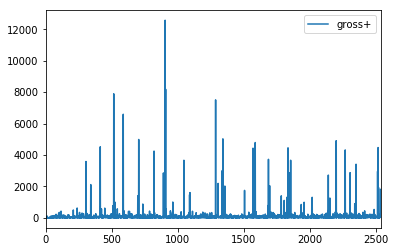

In [51]:
df[['gross+','time']].plot()
plt.show()

In [33]:
ff= './tlogs/201902'
if ff.startswith("./tlogs"):
    print ("yep")

yep


In [18]:
for f in os.walk('./tlogs'): print ("f:",f,"sub:",sub)


f: ('./tlogs', ['201902'], ['.DS_Store']) sub: []
f: ('./tlogs/201902', ['20190202', '20190203', '20190204', '20190205', '20190206', '20190207', '20190208', '20190209', '20190210', '20190211', '20190212', '20190213', '20190214', '20190215', '20190216', '20190217', '20190218', '20190219', '20190220', '20190221', '20190222', '20190223', '20190224', '20190225', '20190226', '20190227', '20190228', '20190301'], ['.DS_Store']) sub: []
f: ('./tlogs/201902/20190202', [], ['checklisting.txt', 'department.txt', 'Department01Discounts.txt', 'Department04Discounts.txt', 'Department06Discounts.txt', 'Department07Discounts.txt', 'Department08Discounts.txt', 'Department09Discounts.txt', 'Department10Discounts.txt', 'Department11Discounts.txt', 'Department12Discounts.txt', 'Department13Discounts.txt', 'Department14Discounts.txt', 'Department15Discounts.txt', 'Department16Discounts.txt', 'Department17Discounts.txt', 'Department19Discounts.txt', 'Department26Discounts.txt', 'dept.txt', 'discountitems.tx

In [ ]:
import os

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".asm"):
            print (filepath)

In [8]:
df=pd.read_pickle('02012019.pkl')

In [10]:
df[df['BANANAS']!=0]

,date,gross+,gross-,items,net,oper,term,time,trans,type,...,PRO BAR MINT CHOC,8213 FENNEL POWDER,OR Cooked Beets,JR Melatonin SR 12,NUT WALNUT,QT Elderbry Loz 36,SW WB Vanilla 12pk,6556 DUTCH COCOA,lvngClyBntonte 8oz,CARDAMOM BITTERS
36,2001-02-19,37.65,0.00,"[[, PASCHA UNSWT CCHIP, 4.99, 15], [, PRIMAVER...",37.65,104,5,09:16,8,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,2001-02-19,108.17,0.00,"[[, FORGER PL CSH YOG, 5.59, 13], [, SO DEL UN...",108.17,42,6,09:20,12,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,2001-02-19,20.72,0.00,"[[, APPLES FUJI, 2.42, 12], [, 8308KEEMUN BLAC...",20.72,11,1,09:27,7,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,2001-02-19,144.42,0.00,"[[, WOODSTK BLUEBERRIE, 6.29, 19], [, EVOLUTIO...",144.42,42,6,09:30,17,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,2001-02-19,17.69,0.00,"[[, COELA ZIPPER TOTE, 9.99, 6], [, BANANAS, 2...",17.69,42,6,09:31,18,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,2001-02-19,224.03,0.00,"[[, APPLE JUICE, 11.39, 15], [, ORG GAL CLOVER...",224.03,104,5,09:32,21,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,2001-02-19,80.01,0.00,"[[, MAC HAWAI SEA SALT, 7.99, 15], [, UMLAUT C...",80.01,42,6,09:35,21,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,2001-02-19,86.51,0.00,"[[, FLAVORG VANILLA4oz, 15.49, 15], [, SUGAR P...",86.51,34,8,09:39,12,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,2001-02-19,285.53,0.00,"[[, VH Kids Vibe Choc, 34.4, 1], [, EZ Ultimat...",285.53,11,1,09:40,18,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,2001-02-19,55.73,0.00,"[[, QRT CAN JAR t101, 1.79, 6], [, QRT CAN JAR...",55.73,42,6,09:41,25,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
df.columns

Index(['date', 'gross+', 'gross-', 'items', 'net', 'oper', 'term', 'time',
       'trans', 'type'],
      dtype='object')

In [ ]:
plt.scatter(x=df['time'],y=df['gross+'])

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
